# Import of packages

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from math import pi
import matplotlib.pyplot as plt

# Setting the number of layers and initializing quantum circuit

In [3]:
n_layers = input("Type number of layers: ")
n_layers = int(n_layers)
num_qubits = 2*n_layers + 2

qreg = QuantumRegister(num_qubits, 'q')
creg = ClassicalRegister(num_qubits, 'c')
qc = QuantumCircuit(qreg, creg)

Type number of layers: 5


# Main Algorithm

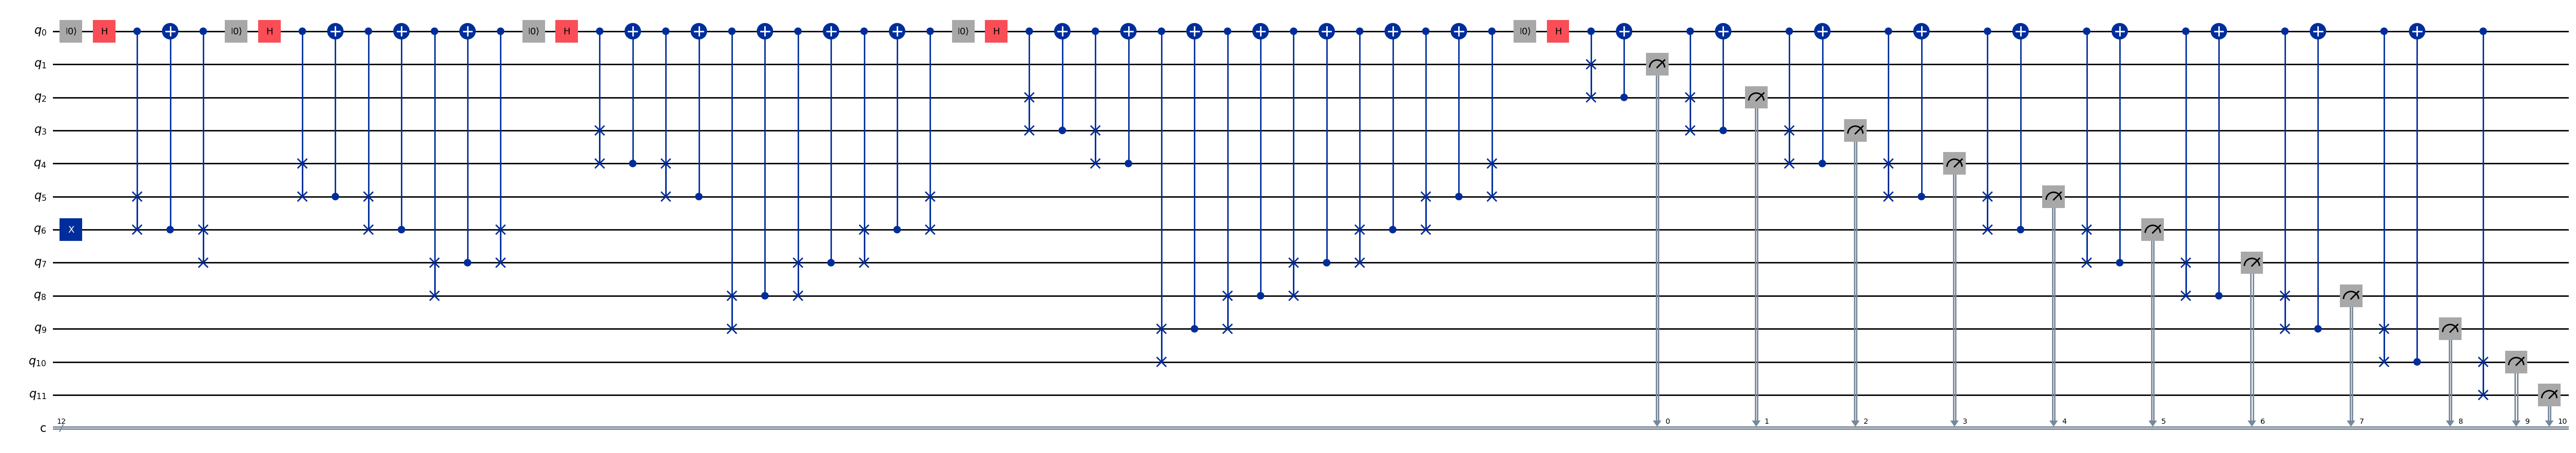

In [4]:
#Algorithm for N-layer Galton Board (Normal Distribution)

#Initializing
qc.reset(qreg[0])
qc.x(qreg[int(num_qubits/2)])

cswap_1 = int(num_qubits/2)
cnot_1 = int(num_qubits/2)
cswap_2 = int(num_qubits/2 + 1)

cswap_3 = int(cswap_1 + 2)
cnot_2 = int(cnot_1 + 1)
cswap_4 = int(cswap_2)

#First Layer
qc.h(qreg[0])

qc.cswap(qreg[0], qreg[cswap_1 - 1], qreg[cswap_1])
qc.cx(qreg[cnot_1], qreg[0])
qc.cswap(qreg[0], qreg[cswap_2 - 1], qreg[cswap_2])

qc.reset(qreg[0])

#Subsequent Layers
for n in range(2, n_layers + 1):
  qc.h(qreg[0])
  cswap_1 = cswap_1 - 1
  cnot_1 = cnot_1 - 1
  cswap_2 = cswap_2 - 1

  qc.cswap(qreg[0], qreg[cswap_1 - 1], qreg[cswap_1])
  qc.cx(qreg[cnot_1], qreg[0])
  qc.cswap(qreg[0], qreg[cswap_2 - 1], qreg[cswap_2])
  qc.cx(qreg[cswap_2], qreg[0]) #rebalance control qubit

  if(n == n_layers):

    for i in range(1, n):
      cswap_1 = cswap_1 + 2
      cnot_1 = cnot_1 + 2
      cswap_2 = cswap_2 + 2
      qc.cswap(qreg[0], qreg[cswap_1 - 1], qreg[cswap_1])
      qc.cx(qreg[cnot_1], qreg[0])
      qc.cswap(qreg[0], qreg[cswap_2 - 1], qreg[cswap_2])
      if(i != n-1):
        qc.cx(qreg[cswap_2], qreg[0]) #rebalance control qubit

  else:
    c3 = cswap_3
    c4 = cswap_4
    for i in range(1,n):
      qc.cswap(qreg[0], qreg[c3 - 1], qreg[c3])
      qc.cx(qreg[cnot_2], qreg[0])
      qc.cswap(qreg[0], qreg[c4 - 1], qreg[c4])
      if (i != n-1):
        cnot_2 = cnot_2 - 1
        qc.cx(qreg[cnot_2], qreg[0])
        cnot_2 = cnot_2 - 1
      c3 = c3 - 2
      c4 = c4 - 2

    qc.reset(qreg[0])
    cswap_3 = cswap_3 + 1
    cnot_2 = cswap_3 - 1
    cswap_4 = cswap_4 + 1

for i in range(1, num_qubits):
  qc.measure(qreg[i], creg[i-1])

qc.draw(output = 'mpl', fold = -1)

# Simulation of obtained results

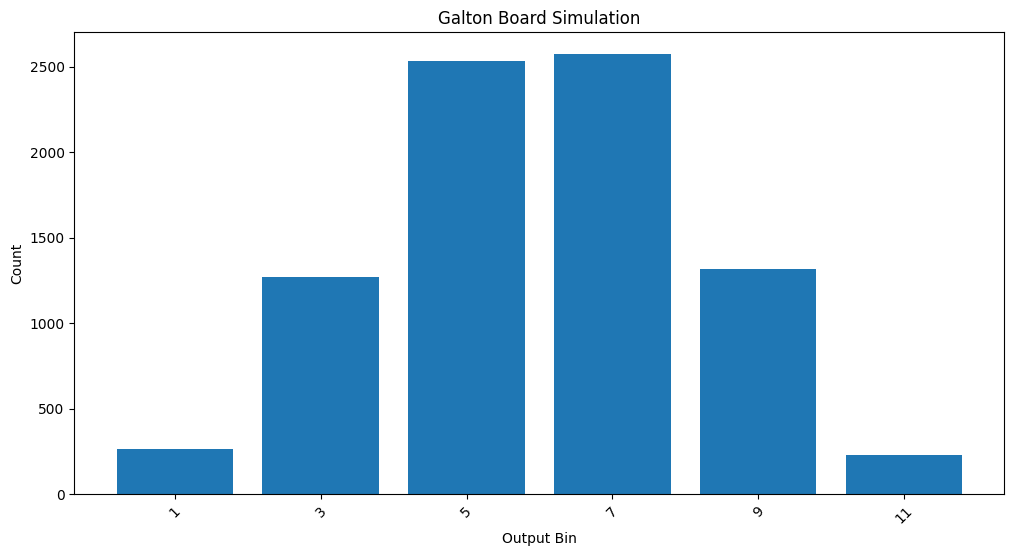

In [5]:
# Simulate the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=8192)
result = job.result()
counts = result.get_counts()

first_outcome = next(iter(counts))
num_measured_qubits = len(first_outcome)

# Process results
processed_counts = {}
for outcome, count in counts.items():
    position = outcome.find('1')
    if position == -1:
        bin_number = num_measured_qubits  # All zeros case
    else:
        bin_number = position

    # Manual correction for last qubit
    if bin_number == num_measured_qubits - 1:
        bin_number = num_measured_qubits - 1
    processed_counts[str(bin_number)] = count

# Post Processing

# 1 Separate the last bin
last_bin = str(num_measured_qubits - 1)
last_bin_value = processed_counts.pop(last_bin, 0)

# 2 Sort remaining bins numerically
sorted_bins = sorted(processed_counts.items(), key=lambda x: int(x[0]))

# 3 Append the last bin at the end
sorted_bins.append((last_bin, last_bin_value))

# 4 Convert back to dictionary
corrected_counts = dict(sorted_bins)

# 5 Prepare data with correct order
bin_order = sorted([int(k) for k in corrected_counts.keys() if k != last_bin]) + [int(last_bin)]
x_labels = [str(k) for k in bin_order]
y_values = [corrected_counts[str(k)] for k in bin_order]

# 6 Create manual bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, y_values)

# 7 Plot the histogram
plt.xlabel("Output Bin")
plt.ylabel("Count")
plt.title("Galton Board Simulation")
plt.xticks(rotation=45)
plt.show()